# 07. Gradient and Autograd Deep Dive

Understanding how PyTorch computes gradients automatically is crucial for deep learning success. This notebook will take you deep into PyTorch's autograd system and help you understand:

- How automatic differentiation works
- The computational graph concept
- Forward and backward propagation in detail
- Gradient accumulation and manipulation
- Common autograd pitfalls and solutions
- Custom gradient functions

**Why is this important?**

Understanding autograd helps you:

- Debug gradient-related issues effectively
- Optimize training performance
- Implement custom training procedures
- Understand what happens "under the hood" in PyTorch


## What is Automatic Differentiation?

Automatic differentiation (autodiff) is a technique for computing derivatives of functions defined by computer programs. Unlike symbolic or numerical differentiation, autodiff can compute exact derivatives efficiently.

### Types of Autodiff:

1. **Forward Mode**: Computes derivatives along with the forward pass
2. **Reverse Mode**: Computes derivatives in a backward pass (used by PyTorch)

### Why Reverse Mode for Deep Learning?

Reverse mode autodiff is particularly efficient for functions with many inputs and few outputs (like neural networks with many parameters and one loss output).


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot  # For visualizing computational graphs
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.7.1
Device: cpu


## The Computational Graph

PyTorch builds a computational graph dynamically as you perform operations. Each tensor operation creates a node in this graph.


In [2]:
# Simple example: y = x^2 + 3x + 1
x = torch.tensor(2.0, requires_grad=True)
print(f"x = {x}")
print(f"x.requires_grad: {x.requires_grad}")

# Perform operations
y = x**2 + 3 * x + 1
print(f"y = {y}")
print(f"y.grad_fn: {y.grad_fn}")

# The computational graph is built!
# Let's visualize it
print(f"\nComputational graph:")
print(f"x -> {x.grad_fn}")
print(f"y -> {y.grad_fn}")

x = 2.0
x.requires_grad: True
y = 11.0
y.grad_fn: <AddBackward0 object at 0x107afc370>

Computational graph:
x -> None
y -> <AddBackward0 object at 0x107bf5a50>


## Computing Gradients with .backward()

The `.backward()` method computes gradients by traversing the computational graph in reverse.


In [3]:
# Compute gradients
y.backward()

print(f"dy/dx = {x.grad}")

# Let's verify this manually
# y = x^2 + 3x + 1
# dy/dx = 2x + 3
# At x = 2: dy/dx = 2(2) + 3 = 7
manual_gradient = 2 * x.data + 3
print(f"Manual calculation: {manual_gradient}")
print(f"PyTorch autograd: {x.grad}")

dy/dx = 7.0
Manual calculation: 7.0
PyTorch autograd: 7.0


## Gradient Accumulation

By default, gradients accumulate in the `.grad` attribute. This is useful for techniques like gradient accumulation for large batch sizes.


In [4]:
# Reset gradients
x.grad = None

# Compute gradients multiple times
for i in range(3):
    y = x**2 + i * x
    y.backward()
    print(f"Iteration {i+1}: x.grad = {x.grad}")

# Gradients are accumulated!
# To clear gradients, use zero_grad() or set to None
x.grad = None
print(f"After reset: x.grad = {x.grad}")

Iteration 1: x.grad = 4.0
Iteration 2: x.grad = 9.0
Iteration 3: x.grad = 15.0
After reset: x.grad = None


## Working with Tensors and Gradients

Let's explore how gradients work with multi-dimensional tensors and multiple variables.


In [5]:
# Multiple variables
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = torch.tensor([4.0, 5.0, 6.0], requires_grad=True)

# Compute a scalar loss
z = torch.sum(x * y + x**2)
print(f"z = {z}")

# Compute gradients
z.backward()

print(f"dz/dx = {x.grad}")
print(f"dz/dy = {y.grad}")

# Manual verification:
# z = sum(x*y + x^2) = sum([1*4 + 1^2, 2*5 + 2^2, 3*6 + 3^2])
# z = sum([5, 14, 27]) = 46
# dz/dx = [y[0] + 2*x[0], y[1] + 2*x[1], y[2] + 2*x[2]]
# dz/dx = [4 + 2*1, 5 + 2*2, 6 + 2*3] = [6, 9, 12]
print(f"Manual dz/dx: {y.data + 2*x.data}")

z = 46.0
dz/dx = tensor([ 6.,  9., 12.])
dz/dy = tensor([1., 2., 3.])
Manual dz/dx: tensor([ 6.,  9., 12.])


## Understanding requires_grad

The `requires_grad` parameter controls whether PyTorch should track operations for gradient computation.


In [6]:
# Tensors with and without gradient tracking
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=False)
c = torch.tensor(4.0)  # requires_grad=False by default

print(f"a.requires_grad: {a.requires_grad}")
print(f"b.requires_grad: {b.requires_grad}")
print(f"c.requires_grad: {c.requires_grad}")

# Operations inherit gradient requirements
result1 = a * b  # Result requires grad because a does
result2 = b * c  # Result doesn't require grad because neither b nor c do

print(f"(a * b).requires_grad: {result1.requires_grad}")
print(f"(b * c).requires_grad: {result2.requires_grad}")

a.requires_grad: True
b.requires_grad: False
c.requires_grad: False
(a * b).requires_grad: True
(b * c).requires_grad: False


## Detaching from the Computational Graph

Sometimes you want to stop gradient computation for certain operations.


In [7]:
x = torch.tensor(2.0, requires_grad=True)

# Normal computation
y1 = x**2
print(f"y1.requires_grad: {y1.requires_grad}")

# Detached computation
y2 = x.detach() ** 2
print(f"y2.requires_grad: {y2.requires_grad}")

# Using torch.inference_mode() (preferred over torch.no_grad())
with torch.inference_mode():
    y3 = x**2
    print(f"y3.requires_grad: {y3.requires_grad}")

# The detached tensor shares storage but not gradient history
print(f"x.data_ptr() == x.detach().data_ptr(): {x.data_ptr() == x.detach().data_ptr()}")

y1.requires_grad: True
y2.requires_grad: False
y3.requires_grad: False
x.data_ptr() == x.detach().data_ptr(): True


## Neural Network Example: Manual Implementation

Let's implement a simple neural network manually to see autograd in action.


Epoch 0, Loss: 1.1897
Epoch 20, Loss: 0.7134
Epoch 40, Loss: 0.5733
Epoch 60, Loss: 0.4824
Epoch 80, Loss: 0.4119


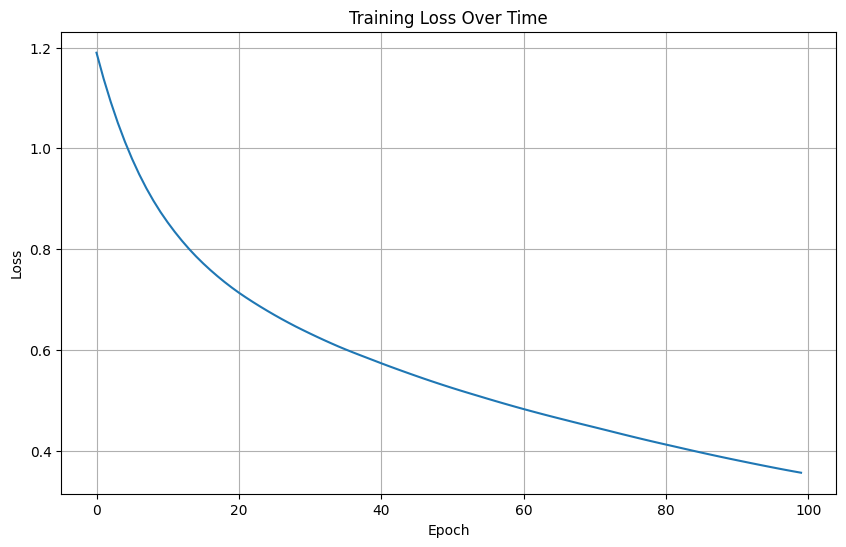

In [8]:
# Create a simple dataset
torch.manual_seed(42)
X = torch.randn(100, 2)  # 100 samples, 2 features
y = (X[:, 0] + X[:, 1] > 0).float().unsqueeze(1)  # Simple classification

# Manual neural network parameters
W1 = torch.randn(2, 5, requires_grad=True)  # Input to hidden
b1 = torch.zeros(5, requires_grad=True)  # Hidden bias
W2 = torch.randn(5, 1, requires_grad=True)  # Hidden to output
b2 = torch.zeros(1, requires_grad=True)  # Output bias


def forward(X):
    """Forward pass through the network"""
    h = torch.relu(X @ W1 + b1)  # Hidden layer
    out = torch.sigmoid(h @ W2 + b2)  # Output layer
    return out


def compute_loss(predictions, targets):
    """Binary cross-entropy loss"""
    return -torch.mean(
        targets * torch.log(predictions + 1e-8)
        + (1 - targets) * torch.log(1 - predictions + 1e-8)
    )


# Training loop
learning_rate = 0.1
losses = []

for epoch in range(100):
    # Forward pass
    predictions = forward(X)
    loss = compute_loss(predictions, y)

    # Backward pass
    loss.backward()

    # Update parameters manually
    with torch.inference_mode():
        W1 -= learning_rate * W1.grad
        b1 -= learning_rate * b1.grad
        W2 -= learning_rate * W2.grad
        b2 -= learning_rate * b2.grad

    # Clear gradients
    W1.grad = None
    b1.grad = None
    W2.grad = None
    b2.grad = None

    losses.append(loss.item())

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Gradient Accumulation for Large Batches

When memory is limited, you can simulate larger batch sizes by accumulating gradients across multiple smaller batches.


In [9]:
# Simulate gradient accumulation
model = nn.Linear(10, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Create some dummy data
X = torch.randn(100, 10)
y = torch.randn(100, 1)

accumulation_steps = 4
batch_size = 8

for epoch in range(5):
    total_loss = 0
    optimizer.zero_grad()  # Clear gradients at the start of each epoch

    for i in range(0, len(X), batch_size):
        # Get mini-batch
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Scale loss by accumulation steps
        loss = loss / accumulation_steps

        # Backward pass (accumulates gradients)
        loss.backward()

        total_loss += loss.item()

        # Update parameters every accumulation_steps
        if (i // batch_size + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Average Loss: {total_loss:.4f}")

Epoch 1, Average Loss: 4.9993
Epoch 2, Average Loss: 4.8793
Epoch 3, Average Loss: 4.7709
Epoch 4, Average Loss: 4.6728
Epoch 5, Average Loss: 4.5839


## Custom Autograd Functions

For advanced use cases, you can define custom autograd functions with custom forward and backward passes.


In [10]:
class SquareFunction(torch.autograd.Function):
    """
    Custom autograd function that squares its input.
    This example shows how to define custom forward and backward passes.
    """

    @staticmethod
    def forward(ctx, input):
        """
        Forward pass: compute the output
        ctx: context object to save information for backward pass
        """
        ctx.save_for_backward(input)  # Save input for backward pass
        return input * input

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass: compute gradient with respect to input
        grad_output: gradient flowing back from the next layer
        """
        (input,) = ctx.saved_tensors  # Retrieve saved input
        grad_input = grad_output * 2 * input  # d/dx(x^2) = 2x
        return grad_input


# Use the custom function
square = SquareFunction.apply

x = torch.tensor(3.0, requires_grad=True)
y = square(x)
print(f"y = {y}")

y.backward()
print(f"dy/dx = {x.grad}")  # Should be 2*3 = 6

y = 9.0
dy/dx = 6.0


## Common Autograd Pitfalls and Solutions

### 1. In-place Operations

In-place operations can cause issues with autograd because they modify tensors that might be needed for gradient computation.


In [11]:
# Problematic in-place operation
x = torch.tensor(2.0, requires_grad=True)
y = x**2

# This would cause an error during backward pass
# x.add_(1)  # In-place addition - DON'T DO THIS!

# Solution: Use non-in-place operations
x_new = x + 1
print("Non-in-place operation successful")

# Or use .detach() if you really need in-place
x_detached = x.detach()
x_detached.add_(1)
print("In-place on detached tensor successful")

Non-in-place operation successful
In-place on detached tensor successful


### 2. Forgetting to Zero Gradients


In [12]:
# Demonstrate the importance of zeroing gradients
x = torch.tensor(2.0, requires_grad=True)

print("Without zeroing gradients:")
for i in range(3):
    y = x**2
    y.backward()
    print(f"Iteration {i+1}: x.grad = {x.grad}")

print("\nWith proper gradient zeroing:")
for i in range(3):
    if x.grad is not None:
        x.grad.zero_()  # or x.grad = None
    y = x**2
    y.backward()
    print(f"Iteration {i+1}: x.grad = {x.grad}")

Without zeroing gradients:
Iteration 1: x.grad = 4.0
Iteration 2: x.grad = 8.0
Iteration 3: x.grad = 12.0

With proper gradient zeroing:
Iteration 1: x.grad = 4.0
Iteration 2: x.grad = 4.0
Iteration 3: x.grad = 4.0


## Gradient Checking

It's good practice to verify your gradients numerically, especially when implementing custom functions.


In [14]:
def numerical_gradient(f, x, h=1e-5):
    """
    Compute numerical gradient using finite differences
    """
    grad = torch.zeros_like(x)

    for i in range(x.numel()):
        # Create copies for perturbation
        x_plus = x.clone()
        x_minus = x.clone()

        # Perturb
        x_plus.view(-1)[i] += h
        x_minus.view(-1)[i] -= h

        # Compute finite difference
        grad.view(-1)[i] = (f(x_plus) - f(x_minus)) / (2 * h)

    return grad


# Test function: f(x) = x^2 + 2*x + 1
def test_function(x):
    return (x**2 + 2 * x + 1).sum()


# Compare numerical and analytical gradients
x = torch.tensor([1.0, 2.0], requires_grad=True)

# Analytical gradient
y = test_function(x)
y.backward()
analytical_grad = x.grad.clone()

# Numerical gradient
x.grad = None
numerical_grad = numerical_gradient(test_function, x.detach())

print(f"Analytical gradient: {analytical_grad}")
print(f"Numerical gradient:  {numerical_grad}")
print(f"Difference: {torch.abs(analytical_grad - numerical_grad)}")

Analytical gradient: tensor([4., 6.])
Numerical gradient:  tensor([4.0054, 6.0081])
Difference: tensor([0.0054, 0.0081])


## Performance Considerations

Understanding autograd performance can help you write more efficient code.


In [15]:
import time

# Large tensor operations
x = torch.randn(1000, 1000, requires_grad=True)

# Time with gradient computation
start_time = time.time()
for _ in range(10):
    y = torch.sum(x**2)
    y.backward()
    x.grad = None
grad_time = time.time() - start_time

# Time without gradient computation
with torch.inference_mode():
    start_time = time.time()
    for _ in range(10):
        y = torch.sum(x**2)
    no_grad_time = time.time() - start_time

print(f"With gradients: {grad_time:.4f}s")
print(f"Without gradients: {no_grad_time:.4f}s")
print(f"Overhead: {((grad_time - no_grad_time) / no_grad_time * 100):.1f}%")

With gradients: 0.0537s
Without gradients: 0.0089s
Overhead: 501.1%


## Best Practices for Autograd

### 1. Use `torch.inference_mode()` for inference

```python
# Preferred for inference
with torch.inference_mode():
    predictions = model(data)
```

### 2. Clear gradients properly

```python
# Method 1: Set to None (more memory efficient)
optimizer.zero_grad()

# Method 2: Manual zeroing
for param in model.parameters():
    param.grad = None
```

### 3. Avoid unnecessary gradient computation

```python
# Only set requires_grad=True for parameters you want to optimize
model_params = [p for p in model.parameters() if p.requires_grad]
```

### 4. Use gradient clipping for stable training

```python
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```


## Summary

In this notebook, we've covered:

1. **How autograd works**: Reverse-mode automatic differentiation
2. **Computational graphs**: How PyTorch tracks operations
3. **Gradient computation**: Using `.backward()` and understanding gradient flow
4. **Gradient manipulation**: Accumulation, detaching, and custom functions
5. **Common pitfalls**: In-place operations, gradient zeroing, and scalar outputs
6. **Performance considerations**: When to use `torch.inference_mode()`
7. **Best practices**: Writing efficient and correct gradient-based code

Understanding autograd deeply will help you:

- Debug gradient-related issues effectively
- Implement custom training procedures
- Optimize model performance
- Build more complex architectures with confidence

### Next Steps:

- Practice implementing custom autograd functions
- Experiment with gradient accumulation strategies
- Try implementing advanced optimizers from scratch
- Explore gradient-based meta-learning techniques
